# Apprentice Chef - Regression Model Development

> *by Jack Daoud, February 11th 2021*

# Setup

In [1]:
# Libraries & Data

##############################################################################
# Import libraries

import pandas as pd                     # data sceince essentials
import matplotlib.pyplot as plt         # essential graphical output
import seaborn as sns                   # enhanced visualizations
import numpy as np                      # mathematical essentials
from tqdm.notebook import tqdm          # progress bars
import time                             # time essentials

t0 = time.time()            # start time of script

# Set Pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##############################################################################
# Import data

# Specify file name
file_data = './_data/Apprentice_Chef_Dataset.xlsx'

# Read file into Python
chefs = pd.read_excel(io     = file_data,
                      header = 0)

##############################################################################
# Fix data

# Rename LARGEST_ORDER_SIZE to AVG_MEALS_ORDERED
chefs.rename(columns={'LARGEST_ORDER_SIZE':'AVG_MEALS_ORDERED'}, inplace=True)

# Print dimensions of data
print(f"""
Size of Original Dataset
------------------------
Observations: {chefs.shape[0]}
Features:     {chefs.shape[1]}
""")


Size of Original Dataset
------------------------
Observations: 1946
Features:     28



# Feature Engineering

In [2]:
# Transformations (3) & Variable Derivations (6)

##############################################################################
# 3 Log transformations

# REVENUE
chefs['log_REVENUE'] = np.log10(chefs['REVENUE'])


# log_AVG_PREP_VID_TIME
chefs['log_AVG_PREP_VID_TIME'] = np.log10(chefs['AVG_PREP_VID_TIME'])


# log_AVG_TIME_PER_SITE_VISIT
chefs['log_AVG_TIME_PER_SITE_VISIT'] = np.log10(chefs['AVG_TIME_PER_SITE_VISIT'])


# log_CONTACTS_W_CUSTOMER_SERVICE
chefs['log_CONTACTS_W_CUSTOMER_SERVICE'] = np.log10(chefs['CONTACTS_W_CUSTOMER_SERVICE'])


##############################################################################
# 6 Derived Variables

# TOTAL_CANCELS (AGGREGATION)
chefs['TOTAL_CANCELS'] = chefs['CANCELLATIONS_BEFORE_NOON'] + chefs['CANCELLATIONS_AFTER_NOON']    
    

# TOTAL_MEALS_DELIVERED (SUBTRACTION)
chefs['TOTAL_MEALS_DELIVERED'] = chefs['TOTAL_MEALS_ORDERED'] - chefs['TOTAL_CANCELS']


# CONTACTS_PER_ORDER (RATIO)
chefs['CONTACTS_PER_ORDER'] = chefs['CONTACTS_W_CUSTOMER_SERVICE'] / chefs['TOTAL_MEALS_ORDERED']
        # consider log_CONTACTS_W_CUSTOMER_SERVICE


# VARIETY_OF_ORDERS (RATIO)
chefs['VARIETY_OF_ORDERS'] = chefs['UNIQUE_MEALS_PURCH'] / chefs['TOTAL_MEALS_ORDERED']


# LATE_MEAL_ORDER_RATIO
chefs['LATE_MEAL_ORDER_RATIO'] = chefs['LATE_DELIVERIES'] / chefs['TOTAL_MEALS_ORDERED']
    

# MEALS PER CLICK (RATIO)
chefs['MEALS_PER_CLICK'] = chefs['AVG_MEALS_ORDERED'] / chefs['AVG_CLICKS_PER_VISIT']

In [3]:
# Binary Variables (8)

# Basic Rule:
# At least 100 observations must be on both sides of the flag (1s and 0s)

# Calculate number of observations with 0s per variable
photos             = sum(chefs['TOTAL_PHOTOS_VIEWED'][:] == 0)       # TOTAL_PHOTOS_VIEWED
early_deliveries   = sum(chefs['EARLY_DELIVERIES'][:] == 0)          # EARLY_DELIVERIES
late_deliveries    = sum(chefs['LATE_DELIVERIES'][:] == 0)           # LATE_DELIVERIES
early_cancellation = sum(chefs['CANCELLATIONS_BEFORE_NOON'][:] == 0) # CANCELLATIONS_BEFORE_NOON
late_cancellation  = sum(chefs['CANCELLATIONS_AFTER_NOON'][:] == 0)  # CANCELLATIONS_AFTER_NOON
canceled           = sum(chefs['TOTAL_CANCELS'][:] == 0)             # TOTAL_CANCELS
subscribers        = sum(chefs['WEEKLY_PLAN'][:] == 0)               # WEEKLY_PLAN
learner            = sum(chefs['MASTER_CLASSES_ATTENDED'][:] == 0)   # MASTER_CLASSES_ATTENDED


# printing a table of the results
print(f"""
                 No\t\tYes
               ---------------------
Viewd Photos   | {photos}\t\t{len(chefs) - photos}
Early Delivery | {early_deliveries}\t\t{len(chefs) - early_deliveries}
Late Delivery  | {late_deliveries}\t\t{len(chefs) - late_deliveries}
Early Cancel   | {early_cancellation}\t\t{len(chefs) - early_cancellation}
Late Cancel    | {late_cancellation}\t\t{len(chefs) - late_cancellation}
Total Cancels  | {canceled}\t\t{len(chefs) - canceled}
Subscribers    | {subscribers}\t\t{len(chefs) - subscribers}
Learner        | {learner}\t\t{len(chefs) - learner}
""")

##############################################################################
# Engineer Features

# dummy variables
chefs['VIEWED_PHOTOS']      = 0
chefs['EARLY_DELIVERY']     = 0
chefs['LATE_DELIVERY']      = 0
chefs['EARLY_CANCELLATION'] = 0
chefs['LATE_CANCELLATION']  = 0
chefs['CANCELED']           = 0
chefs['SUBSCRIBER']         = 0
chefs['LEARNER']            = 0

for index, value in chefs.iterrows():

    # TOTAL_PHOTOS_VIEWED
    if chefs.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        chefs.loc[index, 'VIEWED_PHOTOS'] = 1
        
        
    # EARLY_DELIVERIES
    if chefs.loc[index, 'EARLY_DELIVERIES'] > 0:
        chefs.loc[index, 'EARLY_DELIVERY'] = 1
        
        
    # LATE_DELIVERIES
    if chefs.loc[index, 'LATE_DELIVERIES'] > 0:
        chefs.loc[index, 'LATE_DELIVERY'] = 1
        
        
    # EARLY_CANCELLATION
    if chefs.loc[index, 'CANCELLATIONS_BEFORE_NOON'] > 0:
        chefs.loc[index, 'EARLY_CANCELLATION'] = 1
       
    
    # LATE_CANCELLATION
    if chefs.loc[index, 'CANCELLATIONS_AFTER_NOON'] > 0:
        chefs.loc[index, 'LATE_CANCELLATION'] = 1
        
        
    # TOTAL_CANCELS
    if chefs.loc[index, 'TOTAL_CANCELS'] > 0:
        chefs.loc[index, 'CANCELED'] = 1

        
    # WEEKLY_PLAN
    if chefs.loc[index, 'WEEKLY_PLAN'] > 0:
        chefs.loc[index, 'SUBSCRIBER'] = 1
        
        
    # MASTER_CLASSES_ATTENDED
    if chefs.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
        chefs.loc[index, 'LEARNER'] = 1




                 No		Yes
               ---------------------
Viewd Photos   | 1140		806
Early Delivery | 1167		779
Late Delivery  | 319		1627
Early Cancel   | 667		1279
Late Cancel    | 1667		279
Total Cancels  | 572		1374
Subscribers    | 468		1478
Learner        | 932		1014



In [4]:
# LAST_NAME Binary Variable

"""
This is is a YES/NO variable for customers with a legitimate FAMILY_NAME.
Legitimate means customer's FAMILY_NAME is non-identical to the FIRST_NAME.

- A small portion of users didn't input a family name.
- Another portion inputted their family name identical to their first name.

We will group aforementioned portions into customers with NO LAST_NAME.

This variable assumes that FIRST_NAME and FAMILY_NAME shouldn't be identical.
Some may argue that some people have identical FIRST_NAME and FAMILY_NAME,
however, this is a rare occurance. 

This is based on the reasoning that people who only input first name in a lead
generation form might not be serious and not intend to buy anything (Chase, 2021).
"""

# Count the number of times a space appears in a customers NAME
chefs['LAST_NAME'] = chefs['NAME'].str.count(' ')

# Check if the customer has a last name and flag them
chefs.loc[chefs['LAST_NAME'] > 1, 'LAST_NAME'] = 1

##############################################################################
        
# Plot Number of Customers with missing family names

# Count number of customers with last names
last_names = chefs['LAST_NAME'].value_counts()

# Create plot
ax = last_names.plot(kind='bar', 
                      legend = True,
                      figsize = (8,6),
                      rot = 0,
                      colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title('Customers with Family Names', size = 14)
ax.set_xticklabels(labels = ['Has Family Name', 'No Family Name'])
ax.legend().remove()

# Display plot
#plt.show()
plt.close()

In [5]:
# MEAL_POLARITY Ordinal Variable

"""
This is a ordinal variable that classifies customer polarity based off
their MEDIAN_MEAL_RATING. 
- If the rating is greater than 3 (midpoint), then customer polarity is positive
- If the rating is less than 3, then customer polarity is negative
- If the rating equals 3, then customer polarity neutral

Positive = 1
Neutral  = 0
Negative = -1
"""

# Loop through each customer
for index, column in chefs.iterrows():
    
    # Check if the customer has a positive experience on average
    if chefs.loc[ index , 'MEDIAN_MEAL_RATING'] > 3:
        chefs.loc[ index , 'MEAL_POLARITY'] = 1
    elif chefs.loc[ index , 'MEDIAN_MEAL_RATING'] < 3:
        chefs.loc[ index , 'MEAL_POLARITY'] = -1
    else:
        chefs.loc[ index , 'MEAL_POLARITY'] = 0
        
        
# Change data type to integer
chefs.MEAL_POLARITY = chefs.MEAL_POLARITY.astype(int)

##############################################################################
# Plot Polarity by Customers

# Count number of churn per month
domains = chefs['MEAL_POLARITY'].value_counts()

# Create plot
ax = domains.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title('Polartiy of Customers towards Meal Sets', size = 14)
ax.set_xticklabels(labels = ['Neutral', 'Negative', 'Positive'])
ax.legend().remove()
 
# Display plot
#plt.show()
plt.close()

In [6]:
# ABOVE_AVG_CONTACT_W_CS Binary Variable

"""
This is a binary variable that classifies whether or not a customer contacted
customer service more than the average customer.

If the number contacts a customer has with customer service is higher than
the average (7 contacts), then that customer will have a flag of 1.
"""

# Create complained variable and set it to 0
chefs['ABOVE_AVG_CONTACT_W_CS'] = 0

# Calculate average of contacts with customer_service
AVG_CONTACTS_W_CUSTOMER_SERVICE = chefs['CONTACTS_W_CUSTOMER_SERVICE'].mean()

# Loop through each customer
for index, column in chefs.iterrows():
    
    # Check if the customer has a positive experience on average
    if chefs.loc[ index , 'CONTACTS_W_CUSTOMER_SERVICE'] > AVG_CONTACTS_W_CUSTOMER_SERVICE:
        chefs.loc[ index , 'ABOVE_AVG_CONTACT_W_CS'] = 1
        
##############################################################################       
# Plot Number of Complaining Customers

# Count number of customers who complained
domains = chefs['ABOVE_AVG_CONTACT_W_CS'].value_counts()

# Create plot
ax = domains.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title('Number of Customers with Above Avg Contact with Customer Service', size = 14)
ax.set_xticklabels(labels = ['Above Avg', "Avg & Below"])
ax.legend().remove()
 
# Display plot
#plt.show()
plt.close()

In [7]:
# DOMAIN_GROUP Categorical Variable

"""
This is a categorical variable that classifies email domains based on the 
info provided by the marketing team.
"""

# Loop through each customer
for index, col in chefs.iterrows():
    
        # Check if the customer is personal
        if '@gmail.com' in chefs.loc[index, 'EMAIL'] \
        or '@yahoo.com' in chefs.loc[index, 'EMAIL'] \
        or '@protonmail.com' in chefs.loc[index, 'EMAIL']:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'PERSONAL'
        elif '@me.com' in chefs.loc[index, 'EMAIL'] \
        or '@aol.com' in chefs.loc[index, 'EMAIL'] \
        or '@hotmail.com' in chefs.loc[index, 'EMAIL'] \
        or '@live.com' in chefs.loc[index, 'EMAIL'] \
        or '@msn.com' in chefs.loc[index, 'EMAIL'] \
        or '@passport.com' in chefs.loc[index, 'EMAIL']:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'JUNK'
        else:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'PROFESSIONAL'

##############################################################################
# Plot Number of Customers per Domain Group

# Count number of domain groups
domains = chefs['DOMAIN_GROUP'].value_counts()

# Create plot
ax = domains.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0, 
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title('Number of Customers per Domain Group', size = 14)
ax.legend().remove()

# Display plot
#plt.show()
plt.close()


##############################################################################
# Convert DOMAIN_GROUP into Dummy Variables

# Drop PII variables
chefs.drop(labels  = ['NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME'],
           axis    = 1,
           inplace = True)

# Get Dummies 
chefs = pd.get_dummies(chefs)

# Drop DOMAIN_GROUP_JUNK to abide by n-1 rule for dummies
chefs.drop('DOMAIN_GROUP_JUNK', axis = 1, inplace = True)

In [8]:
# Outlier Flag Variables (14)

# Define function to flag outliers
def flag_outliers(data, variable):
    """
    This function takes in a dataframe and a variable.
    
    Then, it calculates the 25th and 75th quantiles of the variable.
    
    Then, it flags 
    
    1) any data point that precedes the 25th quantile under a variable 
    called low_out_VARIABLE.
    
    2) any data point that exceeds the 75th quantile under a variable called
    high_out_variable. 
    
    Then, it deletes any out_VARIABLE with less than 100 flags.
    
    -----------
    Parameters:
    - DATA 
    - VARIABLE
    """
    # Create placeholder for outlier flag
    data['high_out_'+variable] = 0
    data['low_out_'+variable]  = 0
    
    # Set upper and lower thresholds
    lower_threshold = pd.DataFrame(data.quantile(.25, axis = 0))
    upper_threshold = pd.DataFrame(data.quantile(.75, axis = 0))
    
    # Rename columns for indexing
    lower_threshold.columns = ['LOWER']
    upper_threshold.columns = ['UPPER']
    
    # Loop over each column to change its respective flag
    for index, column in data.iterrows():
        
        # Set conditional for variable & upper threshold
        if data.loc[index, variable] > upper_threshold.loc[variable, 'UPPER']:
            
            # Change outlier flag
            data.loc[index, 'high_out_'+variable] = 1
            
        # Set conditional for variable & lower threshold
        if data.loc[index, variable] < lower_threshold.loc[variable, 'LOWER']:
        
            # Change outlier flag
            data.loc[index, 'low_out_'+variable] = 1
    
    # Check for any variables with < 100 outliers and delete them
    if data['high_out_'+variable].sum() < 100:
        del data['high_out_'+variable]
        
    if data['low_out_'+variable].sum() < 100:
        del data['low_out_'+variable]


# List of variables for outlier flagging
outlier_variables = ['TOTAL_MEALS_ORDERED',
                      'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 
                      'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT',
                      'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 
                      'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
                      'AVG_PREP_VID_TIME', 'TOTAL_PHOTOS_VIEWED',
                      'AVG_MEALS_ORDERED', 'MASTER_CLASSES_ATTENDED', 
                      'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT']


# Run function to flag outliers for original variables
for col in chefs.columns:
    if col in outlier_variables:
        flag_outliers(chefs, col)
        
##############################################################################       
# Plot outlier flags        
def plot_outlier_flags(data, variable):
    """
    This function will take a dataframe and variable and plot the count
    of that variable in a bar plot.
    """
    # Create plot
    ax = data[variable].value_counts().plot(kind     = 'bar',
                                            figsize  = (8,6),
                                            rot      = 0,
                                            colormap = 'Paired')
    
    # Annotate plot with values
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 6),
                    textcoords='offset points')
        
    # Set plot aesthetics
    ax.set_ylabel('# Customers',size = 14)
    ax.set_xlabel('')
    ax.set_title(variable, size = 14)
    
    # Display plot
    plt.show()

    
# Loop through outlier flags and plot bar plots
#for col in chefs.columns:
#    if 'out_' in col:
#        plot_outlier_flags(chefs, col)

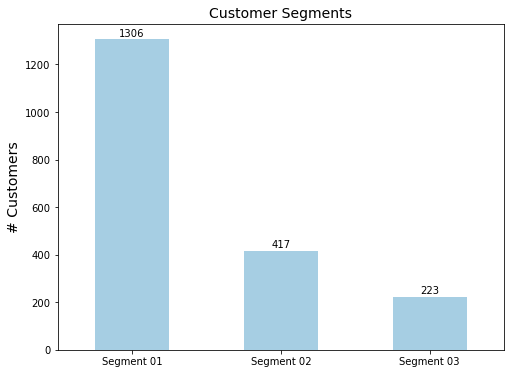

In [9]:
# K-Means Customer Segment Variable
from sklearn.cluster import KMeans                 # Customer segmentation
from sklearn.preprocessing import StandardScaler   # StandardScaler

# Instantiate scaler
scaler = StandardScaler()

# Subset for explanatory variables for customer segmentation EXCLUDING REVENUE
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        'REVENUE','log_REVENUE',
        'log_AVG_PREP_VID_TIME',
        'log_AVG_TIME_PER_SITE_VISIT',
        'log_CONTACTS_W_CUSTOMER_SERVICE'])]].values

# Fit the scaler with our data for customer segmentation
scaler.fit(X)

# Fit the scaler with our data for customer segmentation
X_scaled = scaler.transform(X)

# Instantiate number of clusters
clusterNum = 3

# Instantiate KMEANS model
k_means = KMeans(init         = "k-means++", 
                 n_clusters   = clusterNum, 
                 n_init       = 12,
                 random_state = 219)

# Fit the model
k_means.fit(X_scaled)

# Grab each label (segmentation) for each customer
k_means_labels = k_means.labels_

# Add cluster labels to data set
chefs["KMEANS_CLUSTERS"] = k_means_labels

# Display cluster average per variable
#chefs.groupby('KMEANS_CLUSTERS').mean()

##############################################################################
# Plot 

# Count number of churn per month
genders = chefs['KMEANS_CLUSTERS'].value_counts()

# Create plot
ax = genders.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Customer Segments", size = 14)
ax.set_xticklabels(labels = ['Segment 01', "Segment 02", "Segment 03"])
ax.legend().remove()
 
# Display plot
plt.show()
#plt.close()


##############################################################################
# Plot elbow point for optimal K

# Placeholder
#distortions = []

# Number of Ks
#K = range(1,10)

# Loop through each K
#for k in K:
#    kmeanModel = KMeans(n_clusters=k)
#    kmeanModel.fit(X)                            # Fit with X
#    distortions.append(kmeanModel.inertia_)      # Append inertia to distortions
    
# "Inertia can be recognized as a measure of how internally coherent clusters are."
# https://scikit-learn.org/stable/modules/clustering.html

# Plot elbow point
#plt.figure(figsize=(16,8))
#plt.plot(K, distortions, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
#plt.show()

# Source:
# https://predictivehacks.com/k-means-elbow-method-code-for-python/


##############################################################################
# Convert KMEANS_CLUSTERS into Dummy Variables

# Get dummy variables for KMEANS_CLUSTERS
one_hot_Clusters = pd.get_dummies(chefs['KMEANS_CLUSTERS'])

# Rename columns
one_hot_Clusters.columns = ['KMEANS_CLUSTER_0', 'KMEANS_CLUSTER_1', 'KMEANS_CLUSTER_2']

# Drop cluster 0 to follow n-1 
one_hot_Clusters.drop('KMEANS_CLUSTER_0', axis = 1, inplace = True)


# Drop KMEANS_CLUSTER 
chefs = chefs.drop('KMEANS_CLUSTERS', axis = 1)

# Join dummy variables back to Chefs dataframe
chefs = chefs.join([one_hot_Clusters])

In [10]:
# Export feature rich dataset to excel
#chefs.to_excel(excel_writer = './_data/Feature_Rich_Dataset.xlsx',
#                           index = False)

# Size of feature rich data
print(f"""
Size of Feature Rich Dataset
-----------------------------
Observations: {chefs.shape[0]}
Features:     {chefs.shape[1]}
""")


Size of Feature Rich Dataset
-----------------------------
Observations: 1946
Features:     73



In [11]:
# Identify variables with multicollinearity

# Create correlation dataframe
corr = chefs.corr()

# Unstack and make a dataframe
corr = pd.DataFrame(corr.unstack())

# Reset index to integers rather than variable 01
corr.reset_index(inplace = True)

# Rename columns
corr.columns = ["Var1", "Var2", "Corr"]

# Filter for variables with correlation of greater than 0.8
corr[(corr['Corr'] >= 0.8) & (corr['Corr'] < 1)]\
    .sort_values('Corr', ascending = False)\
    .drop_duplicates(subset=['Corr'])\
    .reset_index()

,index,Var1,Var2,Corr
0,2119,TOTAL_MEALS_DELIVERED,TOTAL_MEALS_ORDERED,0.999576
1,319,CONTACTS_W_CUSTOMER_SERVICE,log_CONTACTS_W_CUSTOMER_SERVICE,0.974019
2,1843,log_AVG_PREP_VID_TIME,AVG_PREP_VID_TIME,0.969869
3,612,CANCELLATIONS_BEFORE_NOON,TOTAL_CANCELS,0.963341
4,2262,CONTACTS_PER_ORDER,KMEANS_CLUSTER_2,0.962949
5,1576,MEDIAN_MEAL_RATING,MEAL_POLARITY,0.955776
6,24,REVENUE,log_REVENUE,0.947122
7,2783,LATE_CANCELLATION,CANCELLATIONS_AFTER_NOON,0.938883
8,3013,LEARNER,MASTER_CLASSES_ATTENDED,0.902861
9,2740,EARLY_CANCELLATION,CANCELED,0.893464


# Models

## 1) Ordinary Least Squares (OLS)

In [12]:
# Run OLS model & print summary

# Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats


# Instantiate independant variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                        
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        'high_out_WEEKLY_PLAN',
        'low_out_WEEKLY_PLAN',
        
        # log exclusions (3 total)
        'AVG_TIME_PER_SITE_VISIT',
        'AVG_PREP_VID_TIME',
        'CONTACTS_W_CUSTOMER_SERVICE',
    
        # high p-values
        'out_EARLY_DELIVERIES',
        'out_LATE_DELIVERIES',
        'WEEKLY_PLAN',
        'REFRIGERATED_LOCKER',
        'AVG_CLICKS_PER_VISIT',
        'LATE_DELIVERY',
        'PC_LOGINS',
        'PRODUCT_CATEGORIES_VIEWED',
        'MOBILE_NUMBER',
        'out_MEDIAN_MEAL_RATING',
        'VIEWED_PHOTOS',
        'EARLY_DELIVERY',
        'CANCELED',
        'DOMAIN_GROUP_PROFESSIONAL',
        'DOMAIN_GROUP_PERSONAL',
        'LATE_DELIVERIES',
        'out_WEEKLY_PLAN',
        'UNIQUE_MEALS_PURCH',
        'ORDERS_PER_PC_LOGIN',
        'out_AVG_MEALS_ORDERED',
        'ABOVE_AVG_CONTACT_W_CS',
        'TOTAL_MEALS_DELIVERED',
        'MOBILE_LOGINS',
        'high_out_AVG_CLICKS_PER_VISIT',
        'low_out_PC_LOGINS',
        'low_out_MOBILE_LOGINS',
        'low_out_TOTAL_MEALS_ORDERED',
        'low_out_AVG_CLICKS_PER_VISIT',
        'low_out_AVG_MEALS_ORDERED',
        'high_out_AVG_PREP_VID_TIME',
        'low_out_LATE_DELIVERIES',
        'high_out_EARLY_DELIVERIES',
        'log_AVG_TIME_PER_SITE_VISIT',
        'KMEANS_CLUSTER_2',
        'TOTAL_CANCELS',
        'high_out_TOTAL_MEALS_ORDERED',
        'LAST_NAME',
        'LATE_CANCELLATION'])]]            


# Instantiate dependant variable
y = chefs.loc[:, 'log_REVENUE']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 219)


# Instantiate linear regression class
linear_regressor = LinearRegression()

# Fit the model
linear_regressor.fit(X_train, y_train)

# Predict log_revenue
ols_pred = linear_regressor.predict(X_test)

# Create a dataframe of variable coefficients
ols_coeff = pd.DataFrame(linear_regressor.coef_, X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
ols_coeff = ols_coeff[ols_coeff['Coefficient'] != 0]\
                .sort_values('Coefficient', ascending = False)

# Create a dataframe of actual vs predicted log_revenue
actual_vs_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': ols_pred})
#print(actual_vs_predicted)

# Scores
linear_train_score = abs(linear_regressor.score(X_train, y_train)).round(4) # using R-square
linear_test_score  = abs(linear_regressor.score(X_test, y_test)).round(4)   # using R-square
linear_test_gap    = abs(linear_train_score - linear_test_score).round(4)

##############################################################################
# Print model summary

# Instantiate list of used explarotary variable names
xlabels = chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                     
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        'high_out_WEEKLY_PLAN',
        'low_out_WEEKLY_PLAN',
        
        # log exclusions (5 total)
        'AVG_TIME_PER_SITE_VISIT',
        'AVG_PREP_VID_TIME',
        'CONTACTS_W_CUSTOMER_SERVICE',
    
        # high p-values
        'out_EARLY_DELIVERIES',
        'out_LATE_DELIVERIES',
        'WEEKLY_PLAN',
        'REFRIGERATED_LOCKER',
        'AVG_CLICKS_PER_VISIT',
        'LATE_DELIVERY',
        'PC_LOGINS',
        'PRODUCT_CATEGORIES_VIEWED',
        'MOBILE_NUMBER',
        'out_MEDIAN_MEAL_RATING',
        'VIEWED_PHOTOS',
        'EARLY_DELIVERY',
        'CANCELED',
        'DOMAIN_GROUP_PROFESSIONAL',
        'DOMAIN_GROUP_PERSONAL',
        'LATE_DELIVERIES',
        'out_WEEKLY_PLAN',
        'UNIQUE_MEALS_PURCH',
        'ORDERS_PER_PC_LOGIN',
        'out_AVG_MEALS_ORDERED',
        'ABOVE_AVG_CONTACT_W_CS',
        'TOTAL_MEALS_DELIVERED',
        'MOBILE_LOGINS',
        'high_out_AVG_CLICKS_PER_VISIT',
        'low_out_PC_LOGINS',
        'low_out_MOBILE_LOGINS',
        'low_out_TOTAL_MEALS_ORDERED',
        'low_out_AVG_CLICKS_PER_VISIT',
        'low_out_AVG_MEALS_ORDERED',
        'high_out_AVG_PREP_VID_TIME',
        'low_out_LATE_DELIVERIES',
        'high_out_EARLY_DELIVERIES',
        'log_AVG_TIME_PER_SITE_VISIT',
        'KMEANS_CLUSTER_2',
        'TOTAL_CANCELS',
        'high_out_TOTAL_MEALS_ORDERED',
        'LAST_NAME',
        'LATE_CANCELLATION'])]

# Print model output:
print(f"""
=================== MODEL SUMMARY ===================


Model Type: Ordinary Least Squares (OLS)

Model Size: {len(xlabels) + 1}


---------------------------------


OLS Training Score : {linear_train_score}
OLS Testing Score  : {linear_test_score}
OLS Train-Test Gap : {linear_test_gap}


---------------------------------

""")

stats.summary(linear_regressor, X, y, xlabels)

# Code for SKLEARN p-values comes from:
# https://stackoverflow.com/questions/44495667/calculate-p-value-in-sklearn-using-python


=================== MODEL SUMMARY ===================


Model Type: Ordinary Least Squares (OLS)

Model Size: 28


---------------------------------


OLS Training Score : 0.7667
OLS Testing Score  : 0.7704
OLS Train-Test Gap : 0.0037


---------------------------------


Residuals:
    Min      1Q  Median     3Q    Max
-0.4228 -0.0623 -0.0043 0.0545 0.6794


Coefficients:
                                      Estimate  Std. Error  t value   p value
_intercept                            1.860476    0.078129  23.8130  0.000000
CROSS_SELL_SUCCESS                   -0.017157    0.004889  -3.5096  0.000459
TASTES_AND_PREFERENCES                0.010179    0.005034   2.0220  0.043314
PACKAGE_LOCKER                       -0.012985    0.004832  -2.6876  0.007258
log_AVG_PREP_VID_TIME                 0.542612    0.020783  26.1089  0.000000
log_CONTACTS_W_CUSTOMER_SERVICE       0.365999    0.035403  10.3382  0.000000
CONTACTS_PER_ORDER                   -0.370769    0.022592 -16.4119  0.000000

## 2) Lasso

In [13]:
# Run LASSO model & print summary

# Libraries
from sklearn.linear_model import Lasso


# Instantiate independant variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                     
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        
        # log exclusions
        'log_AVG_TIME_PER_SITE_VISIT',
        'log_AVG_PREP_VID_TIME',
        'log_CONTACTS_W_CUSTOMER_SERVICE'])]]          

# Instantiate dependant variable
y = chefs.loc[:, 'REVENUE']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 219)


# Instantiate linear regression class
lasso_regressor = Lasso(max_iter = 100000)

# Fit the model
lasso_regressor.fit(X_train, y_train)

# Predict log_revenue
lasso_pred = lasso_regressor.predict(X_test)

# Create a dataframe of variable coefficients
lasso_coeff = pd.DataFrame(lasso_regressor.coef_, X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
lasso_coeff = lasso_coeff[lasso_coeff['Coefficient'] != 0]\
                .sort_values('Coefficient', ascending = False)


# Scores
lasso_train_score = abs(lasso_regressor.score(X_train, y_train)).round(4) # using R-square
lasso_test_score  = abs(lasso_regressor.score(X_test, y_test)).round(4)   # using R-square
lasso_test_gap    = abs(lasso_train_score - lasso_test_score).round(4)

##############################################################################
# Print model summary

print(f"""
=================== MODEL SUMMARY ===================


Model Type: Lasso

Model Size: {len(lasso_coeff) + 1}


---------------------------------


Lasso Training Score : {lasso_train_score}
Lasso Testing Score  : {lasso_test_score}
Lasso Train-Test Gap : {lasso_test_gap}


---------------------------------

Coefficients:
""")

print(lasso_coeff)


=================== MODEL SUMMARY ===================


Model Type: Lasso

Model Size: 57


---------------------------------


Lasso Training Score : 0.718
Lasso Testing Score  : 0.7429
Lasso Train-Test Gap : 0.0249


---------------------------------

Coefficients:

                                      Coefficient
high_out_MEDIAN_MEAL_RATING            557.102160
low_out_UNIQUE_MEALS_PURCH             517.819530
low_out_AVG_TIME_PER_SITE_VISIT        254.589317
high_out_TOTAL_PHOTOS_VIEWED           207.825414
high_out_MASTER_CLASSES_ATTENDED       197.019958
MEAL_POLARITY                          169.776501
LEARNER                                151.374806
high_out_AVG_PREP_VID_TIME             140.727824
low_out_PRODUCT_CATEGORIES_VIEWED      138.372080
CONTACTS_W_CUSTOMER_SERVICE            126.188875
high_out_AVG_TIME_PER_SITE_VISIT       119.652229
low_out_AVG_PREP_VID_TIME              108.014268
low_out_CONTACTS_W_CUSTOMER_SERVICE    100.989460
KMEANS_CLUSTER_1              

## 3) Bayesian Automatic Relevance Determination (ARD)

In [14]:
# Run ARD model & print summary

# Libraries
from sklearn.linear_model import ARDRegression


# Instantiate independant variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                     
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        
        # log exclusions
        'log_AVG_TIME_PER_SITE_VISIT',
        'log_AVG_PREP_VID_TIME',
        'log_CONTACTS_W_CUSTOMER_SERVICE'])]]      

# Instantiate dependant variable
y = chefs.loc[:, 'REVENUE']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 219)


# Instantiate linear regression class
ard_regressor = ARDRegression()

# Fit the model
ard_regressor.fit(X_train, y_train)

# Predict log_revenue
ard_pred = ard_regressor.predict(X_test)

# Create a dataframe of variable coefficients
ard_coeff = pd.DataFrame(ard_regressor.coef_, X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
ard_coeff = ard_coeff[ard_coeff['Coefficient'] != 0]\
                .sort_values('Coefficient', ascending = False)

# Scores
ard_train_score = abs(ard_regressor.score(X_train, y_train)).round(4) # using R-square
ard_test_score  = abs(ard_regressor.score(X_test, y_test)).round(4)   # using R-square
ard_test_gap    = abs(ard_train_score - ard_test_score).round(4)

##############################################################################
# Print model summary

print(f"""
=================== MODEL SUMMARY ===================


Model Type: ARD

Model Size: {len(ard_coeff) + 1}


---------------------------------


ARD Training Score : {ard_train_score}
ARD Testing Score  : {ard_test_score}
ARD Train-Test Gap : {ard_test_gap}


---------------------------------

Coefficients:
""")

print(ard_coeff)


=================== MODEL SUMMARY ===================


Model Type: ARD

Model Size: 59


---------------------------------


ARD Training Score : 0.7151
ARD Testing Score  : 0.7461
ARD Train-Test Gap : 0.031


---------------------------------

Coefficients:

                                      Coefficient
high_out_MEDIAN_MEAL_RATING            632.649598
low_out_UNIQUE_MEALS_PURCH             574.288781
low_out_AVG_TIME_PER_SITE_VISIT        269.648261
high_out_TOTAL_PHOTOS_VIEWED           198.322247
high_out_MASTER_CLASSES_ATTENDED       194.141628
MEAL_POLARITY                          180.580561
LEARNER                                154.821496
high_out_AVG_PREP_VID_TIME             148.162996
CONTACTS_W_CUSTOMER_SERVICE            135.778659
low_out_PRODUCT_CATEGORIES_VIEWED      121.461056
low_out_AVG_PREP_VID_TIME               88.150359
high_out_AVG_TIME_PER_SITE_VISIT        87.699542
low_out_CONTACTS_W_CUSTOMER_SERVICE     81.935411
low_out_AVG_CLICKS_PER_VISIT          

## 4) K Nearest Neighbors

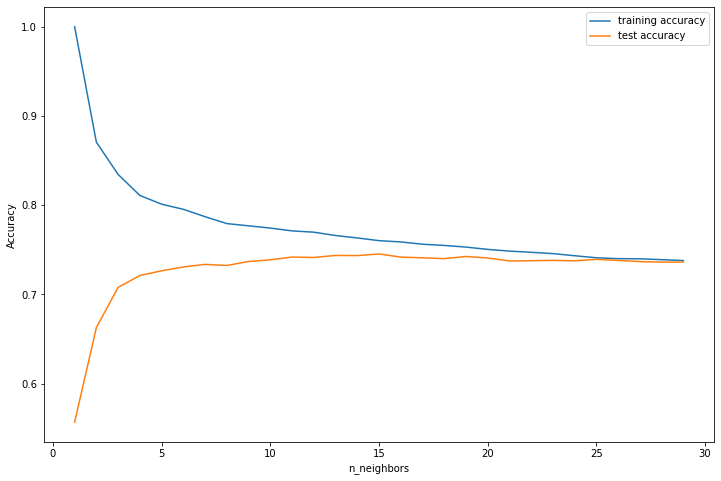


=================== MODEL SUMMARY ===================


Model Type: KNN

Model Size: NA


---------------------------------


KNN Training Score : 0.7603
KNN Testing Score  : 0.7454
KNN Train-Test Gap : 0.0149


---------------------------------



In [18]:
# Run KNN model & print summary

# Import model
from sklearn.neighbors import KNeighborsRegressor # KNN for Regression

##############################################################################
# Prepare data for model

# Instantiate independant variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variables
        'REVENUE','log_REVENUE',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                     
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        'high_out_WEEKLY_PLAN',
        'low_out_WEEKLY_PLAN',
        
        # log exclusions (5 total)
        'AVG_TIME_PER_SITE_VISIT',
        'AVG_PREP_VID_TIME',
        'CONTACTS_W_CUSTOMER_SERVICE',
    
        # high p-values
        'out_EARLY_DELIVERIES',
        'out_LATE_DELIVERIES',
        'WEEKLY_PLAN',
        'REFRIGERATED_LOCKER',
        'AVG_CLICKS_PER_VISIT',
        'LATE_DELIVERY',
        'PC_LOGINS',
        'PRODUCT_CATEGORIES_VIEWED',
        'MOBILE_NUMBER',
        'out_MEDIAN_MEAL_RATING',
        'VIEWED_PHOTOS',
        'EARLY_DELIVERY',
        'CANCELED',
        'DOMAIN_GROUP_PROFESSIONAL',
        'DOMAIN_GROUP_PERSONAL',
        'LATE_DELIVERIES',
        'GENDER',
        'out_WEEKLY_PLAN',
        'UNIQUE_MEALS_PURCH',
        'ORDERS_PER_PC_LOGIN',
        'out_AVG_MEALS_ORDERED',
        'ABOVE_AVG_CONTACT_W_CS',
        'TOTAL_MEALS_DELIVERED',
        'MOBILE_LOGINS',
        'high_out_AVG_CLICKS_PER_VISIT',
        'low_out_PC_LOGINS',
        'low_out_MOBILE_LOGINS',
        'low_out_TOTAL_MEALS_ORDERED',
        'low_out_AVG_CLICKS_PER_VISIT',
        'low_out_AVG_MEALS_ORDERED',
        'high_out_AVG_PREP_VID_TIME',
        'low_out_LATE_DELIVERIES',
        'high_out_EARLY_DELIVERIES',
        'log_AVG_TIME_PER_SITE_VISIT'])]]     

# Instantiate dependant variable
y = chefs.loc[:, 'log_REVENUE']

# Fit the scaler
scaler.fit(X)

# Transform the fitted scaler
X_scaled = scaler.transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size = 0.25, random_state = 219)


##############################################################################
# Check for optimal K

# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy     = []


# building a visualization of 1 to 50 neighbors
neighbors_settings = range(1, 30)


for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors = n_neighbors)
    clf.fit(X_train, y_train)
    
    # Recording the training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    
    # Recording the generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))


# plotting the visualization
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()
#plt.close()


# finding the optimal number of neighbors
opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1



##############################################################################
# Create model

# Instantiate a KNN model object
knn_reg = KNeighborsRegressor(algorithm = 'auto',
                              n_neighbors = opt_neighbors)


# Fit to the training data
knn_fit = knn_reg.fit(X_train, y_train)


# Predict on new data
knn_pred = knn_fit.predict(X_test)

# saving scoring data for future use
knn_train_score = knn_reg.score(X_train, y_train).round(4)
knn_test_score  = knn_reg.score(X_test, y_test).round(4)
knn_test_gap    = abs(knn_train_score - knn_test_score).round(4)


##############################################################################
# Print model summary

print(f"""
=================== MODEL SUMMARY ===================


Model Type: KNN

Model Size: NA


---------------------------------


KNN Training Score : {knn_train_score}
KNN Testing Score  : {knn_test_score}
KNN Train-Test Gap : {knn_test_gap}


---------------------------------
""")

## Predictions

In [16]:
# Consolidate predictions & deviations into a dataframe
prediction_results = pd.DataFrame(data = {
    'Original Revenue'     : (10**y_test),                                       # transform back to original
    'LR Predictions'       : (10**ols_pred).round(decimals = 2),                 # transform back to original
    'Lasso Predictions'    : lasso_pred.round(decimals = 2),
    'ARD Predictions'      : ard_pred.round(decimals = 2),
    'KNN Predictions'      : (10**knn_pred).round(decimals = 2),                 # transform back to original
    'LR Deviation'         : (10**ols_pred).round(decimals = 2) - (10**y_test),  # transform back to original
    'Lasso Deviation'      : lasso_pred.round(decimals = 2) - (10**y_test),      # transform back to original
    'ARD Deviation'        : ard_pred.round(decimals = 2) - (10**y_test),        # transform back to original
    'KNN Deviation'        : (10**knn_pred).round(decimals = 2) - (10**y_test)   # transform back to original
    })

# Export predictions
#prediction_results.to_excel(excel_writer = './_model_results/model_predictions.xlsx',
#                            index = False)

t1 = time.time()      # end time of script

#prediction_results

## Comparison & Final Model

In [17]:
# Model Comparison Summary

total_time = round(t1 - t0)      # compute time taken to run entire script


print(f"""

======================================= Model Comparison ========================================


Model      Train Score      Test Score      Train-Test Gap        Model Size
-----      -----------      ----------      ---------------      -----------           
OLS        {linear_train_score}           {linear_test_score}          {linear_test_gap}               {len(xlabels)+1}
Lasso      {lasso_train_score}            {lasso_test_score}          {lasso_test_gap}               {len(lasso_coeff)+1}
ARD        {ard_train_score}           {ard_test_score}          {ard_test_gap}                {len(ard_coeff)+1}
KNN        {knn_train_score}           {knn_test_score}          {knn_test_gap}               NA


     /-----------------------------------------------------------------------------------\\
     | OLS is the final model with a test score of {linear_test_score}, a train-test gap of {linear_test_gap}.   |
     \\-----------------------------------------------------------------------------------/





OLS Coefficients:

{ols_coeff}


Interested in coefficients of other models? Please scroll up to the output of that respective model.

Total run time of script: {total_time} seconds.
""")

# Create dictionary for model results
model_performance = {
    
    'Model Type'    : ['OLS', 'Lasso', 'ARD', 'KNN'],
           
    'Training' : [linear_train_score, lasso_train_score, 
                  ard_train_score, knn_train_score],
           
    'Testing'  : [linear_test_score, lasso_test_score, 
                  ard_test_score, knn_test_score],
                    
    'Train-Test Gap' : [linear_test_gap, lasso_test_gap, 
                        ard_test_gap, knn_test_gap],
                    
    'Model Size' : [len(xlabels)+1, len(lasso_coeff)+1,
                                    len(ard_coeff)+1, 'NA']}


# Convert model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


# Export model results to excel
#model_performance.to_excel('./_model_results/model_performance.xlsx',

#                           index = False)



======================================= Model Comparison ========================================


Model      Train Score      Test Score      Train-Test Gap        Model Size
-----      -----------      ----------      ---------------      -----------           
OLS        0.7667           0.7704          0.0037               28
Lasso      0.718            0.7429          0.0249               57
ARD        0.7151           0.7461          0.031                59
KNN        0.7603           0.7454          0.0149               NA


     /-----------------------------------------------------------------------------------\
     | OLS is the final model with a test score of 0.7704, a train-test gap of 0.0037.   |
     \-----------------------------------------------------------------------------------/





OLS Coefficients:

                                      Coefficient
log_AVG_PREP_VID_TIME                    0.542612
log_CONTACTS_W_CUSTOMER_SERVICE          0.365999
low_out_UNIQ